In [ ]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import classification_report,accuracy_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_dir = "/content/drive/MyDrive/dataset botol"

In [ ]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split

# # Path dataset asli dan folder baru untuk hasil pemisahan
# dataset_dir = "/content/drive/MyDrive/dataset botol"
# split_dataset_dir = "/content/drive/MyDrive/dataset_split2"

# # Kategori gambar botol
# categories = ['DamagedBottle', 'BotolRecycle', 'FullBottle']


In [ ]:
# # Membuat folder train dan test untuk setiap kategori di folder dataset_split
# for category in categories:
#     os.makedirs(os.path.join(split_dataset_dir, 'train', category), exist_ok=True)
#     os.makedirs(os.path.join(split_dataset_dir, 'test', category), exist_ok=True)


In [ ]:
train_dir = "/content/drive/MyDrive/dataset_split2/train"
test_dir = "/content/drive/MyDrive/dataset_split2/test"

In [ ]:

categories = ['DamagedBottle', 'BotolRecycle', 'FullBottle']

for split in ['train', 'test']:
    print(f"\nJumlah gambar di folder {split}:")
    for category in categories:
        category_dir = os.path.join(train_dir if split == 'train' else test_dir, category)
        if os.path.exists(category_dir):
            num_images = len(os.listdir(category_dir))
            print(f"  Kategori {category}: {num_images} gambar")
        else:
            print(f"  Folder {category} tidak ditemukan di {split}")



Jumlah gambar di folder train:
  Kategori DamagedBottle: 266 gambar
  Kategori BotolRecycle: 263 gambar
  Kategori FullBottle: 340 gambar

Jumlah gambar di folder test:
  Kategori DamagedBottle: 67 gambar
  Kategori BotolRecycle: 66 gambar
  Kategori FullBottle: 85 gambar


In [ ]:
train_datagen = ImageDataGenerator(rescale =1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode="nearest",
                                   validation_split=0.2)

train_generator=train_datagen.flow_from_directory(train_dir,
                                                  target_size=(128,128),
                                                  color_mode="rgb",
                                                  batch_size=32,
                                                  class_mode="categorical",
                                                  subset="training")

valid_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(128,128),
                                                    batch_size=32,
                                                    color_mode="rgb",
                                                    class_mode="categorical",
                                                    subset="validation")

test_datagen = ImageDataGenerator(rescale =1./255)
test_generator = train_datagen.flow_from_directory(test_dir,
                                                   target_size=(128,128),
                                                   color_mode="rgb",
                                                   batch_size=32,
                                                   class_mode="categorical")


Found 696 images belonging to 3 classes.
Found 173 images belonging to 3 classes.
Found 218 images belonging to 3 classes.


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weight Dictionary:")
print(class_weight_dict)

Class Weight Dictionary:
{0: 1.099526066350711, 1: 1.0892018779342723, 2: 0.8529411764705882}


In [ ]:
# Load the MobileNetV2 model pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model
base_model.trainable = False

In [ ]:
from tensorflow.keras.models import Model
# Memulai dengan output dari base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # Gunakan categorical_crossentropy untuk target one-hot
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight_dict
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5929 - loss: 1.0132 - val_accuracy: 0.5491 - val_loss: 1.2401 - learning_rate: 0.0010
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8636 - loss: 0.3976 - val_accuracy: 0.6185 - val_loss: 0.9345 - learning_rate: 0.0010
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8871 - loss: 0.3042 - val_accuracy: 0.7110 - val_loss: 0.8232 - learning_rate: 0.0010
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9112 - loss: 0.2320 - val_accuracy: 0.6936 - val_loss: 0.7001 - learning_rate: 0.0010
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9063 - loss: 0.2844 - val_accuracy: 0.7225 - val_loss: 0.7190 - learning_rate: 0.0010
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9195 - loss: 0.2269 - val_accuracy: 0.6763 - val_loss: 0.9577 - learning_rate: 0.0010
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8999 - loss: 0.2446 - val_accuracy: 0.7168 - va

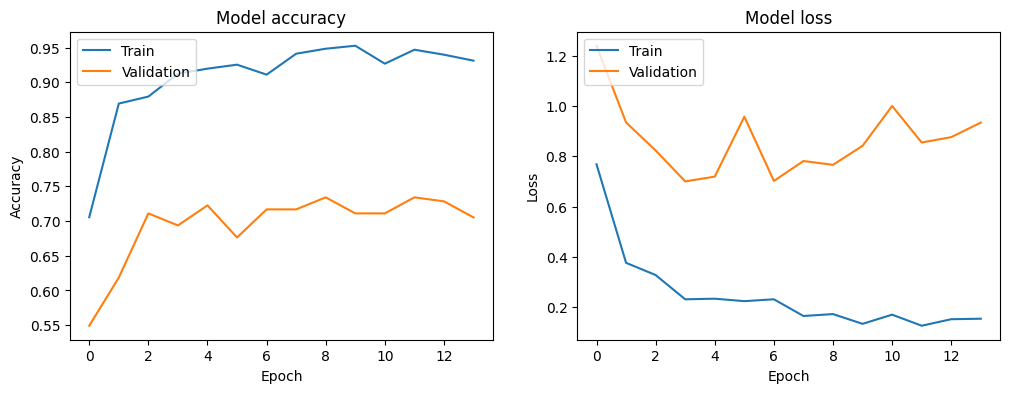

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 49s 9s/step - accuracy: 0.8737 - loss: 0.3448
Test Loss: 0.3764744699001312
Test Accuracy: 0.859375


In [ ]:
model.save( "/content/drive/MyDrive/dataset_split2/mymodel.h5")

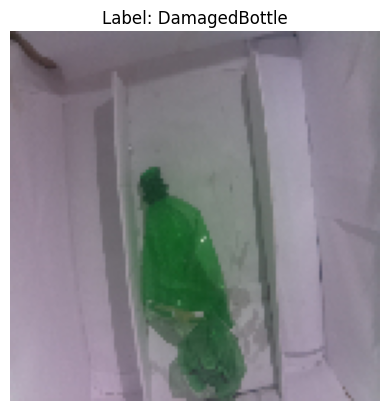

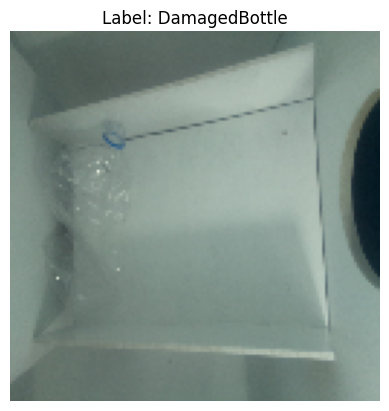

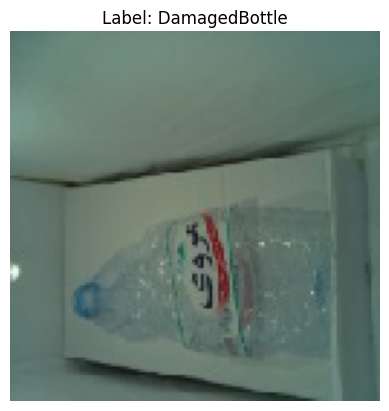

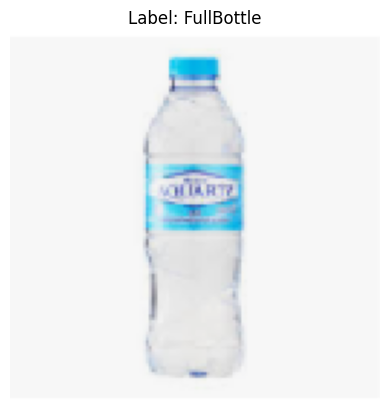

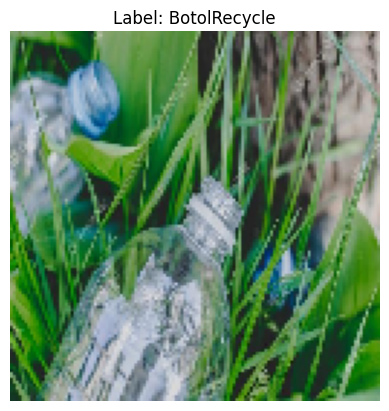

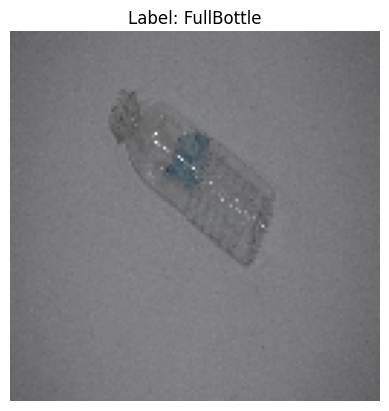

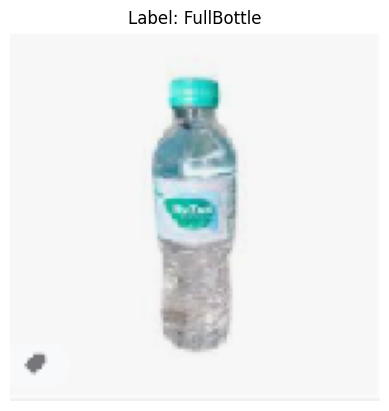

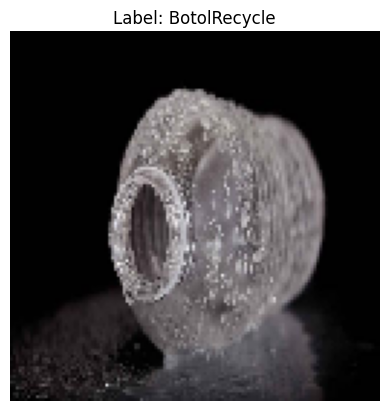

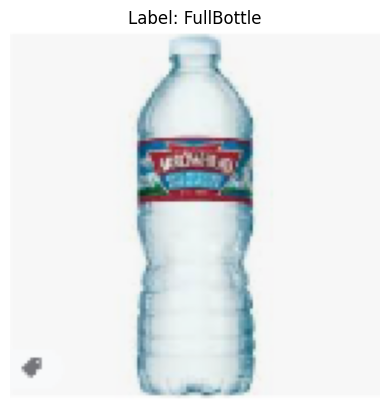

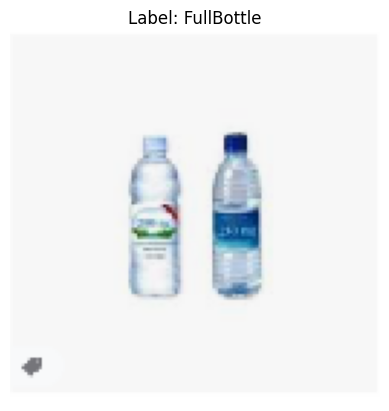

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


# Get the list of categories (subfolders)
categories = os.listdir(test_dir)

# Function to load and display a random image with its label
def load_and_display_random_image_with_label():
    # Randomly select a category (label)
    category = random.choice(categories)

    # Get the list of image files in the selected category
    category_path = os.path.join(test_dir, category)
    files = os.listdir(category_path)

    # Randomly select a file
    selected_file = random.choice(files)
    selected_image_path = os.path.join(category_path, selected_file)

    # Load and preprocess the image
    img = image.load_img(selected_image_path, target_size=(128, 128))

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(f"Label: {category}")  # Display the label as title
    plt.show()

# Display two random images with their labels
for _ in range(10):
    load_and_display_random_image_with_label()


In [ ]:
def load_and_preprocess_image(img_path, target_size=(128, 128)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array

In [ ]:
def display_image(img_path):
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:

def predict_image(model, img_path, class_labels):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions) * 100  # Convert to percentage
    return class_labels[predicted_class], confidence

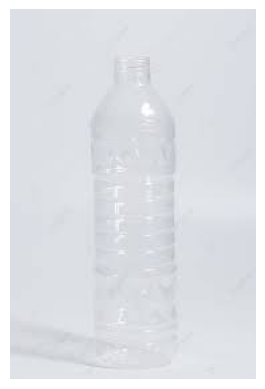

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Predicted Class: BotolRecycle, Confidence: 99.33%


In [ ]:
img_path = '/content/download (12).jpg'

# Define the class labels based on your dataset
class_labels = ['BotolRecycle','DamagedBottle', 'FullBottle']

# Display the image
display_image(img_path)

# Predict the image
predicted_class, confidence = predict_image(model, img_path, class_labels)
print(f'Predicted Class: {predicted_class}, Confidence: {confidence:.2f}%')
